In [1]:
import scipy
import scipy.fftpack
import scipy.special
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time
from pathlib import Path
import pickle
import timeit
import sys, os
import pandas as pd

import pycoss.surface as surface
import pycoss.surface.interp.FFT as FFT
from pycoss.surface.helpers import *
from pycoss.surface.integrators import *
import pycoss.surface.helpers.plotting as plotting

In [2]:
np.seterr(all='raise')
import warnings
warnings.filterwarnings(action="error", category=np.ComplexWarning)

In [3]:
def run_sim(run_name, dt, integrator):

    # +
    Lu0 = 1
    Lv0 = 2
    dim = 3

    shell_width = 0.1

    Nmu = 20
    Nmv = 20

    Mmu_render = Nmu*4
    Mmv_render = Nmv*4

    Mmu_save = Nmu*2
    Mmv_save = Nmv*2

    random_seed = 332325

    # Simulation parameters

    T = 0.01
    taylor_tol = 1e-2

    # Misc

    N_save = 10
    N_clock = 100
    N_integrator_trials = int(1e3)
    # -

    # ## Initial conditions

    if random_seed != -1:
        np.random.seed(random_seed)

    path_handler = surface.interp.cheb.ChebHandler(dim, Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)
    path_handler_render = surface.interp.cheb.ChebHandler(dim, Mmu_render, Mmv_render, Lu0, Lv0, mpmath_dps=-1)

    # +
    thu0 = np.zeros((3, Nmu, Nmv))
    thv0 = np.zeros((3, Nmu, Nmv))
    piu0 = np.zeros((3, Nmu, Nmv))
    piv0 = np.zeros((3, Nmu, Nmv))

    thu0[1] = 1
    thv0[2] = 1

    piu0[1] = 0
    piv0[0] = 0

    Fr_uv0 = np.eye(4)

    R, E = reconstruct_surface(thu0, thv0, piu0, piv0, Fr_uv0, Mmu_render, Mmv_render, Mmu_save, Mmv_save, path_handler_render)

    # +
    X_path_handler = pycoss.surface.interp.cheb.ChebHandler((4,4), Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)

    piu0_hat = hat_vec_to_mat(piu0)
    piv0_hat = hat_vec_to_mat(piv0)

    Xu = construct_se3_elem(thu0, piu0_hat)
    Xv = construct_se3_elem(thv0, piv0_hat)

    dv_Xu = X_path_handler.diffv_f(Xu)
    du_Xv = X_path_handler.diffu_f(Xv)
    ad_Xu_Xv = np.einsum('ijuv,jkuv->ikuv', Xu, Xv) - np.einsum('ijuv,jkuv->ikuv', Xv, Xu)

    np.max(np.abs((du_Xv + ad_Xu_Xv) - dv_Xu))
    # -

    fig = plt.figure(figsize=(10,10))
    plotting.plot_surface(R, E, shell_width, fig=fig)
    plt.close(fig)

    # +
    X_path_handler = pycoss.surface.interp.cheb.ChebHandler((4,4), Nmu, Nmv, Lu0, Lv0, mpmath_dps=-1)

    piu0_hat = hat_vec_to_mat(piu0)
    piv0_hat = hat_vec_to_mat(piv0)

    Xu = construct_se3_elem(thu0, piu0_hat)
    Xv = construct_se3_elem(thv0, piv0_hat)

    dv_Xu = X_path_handler.diffv_f(Xu)
    du_Xv = X_path_handler.diffu_f(Xv)
    ad_Xu_Xv = np.einsum('ijuv,jkuv->ikuv', Xu, Xv) - np.einsum('ijuv,jkuv->ikuv', Xv, Xu)

    np.max(np.abs((du_Xv + ad_Xu_Xv) - dv_Xu))
    # -

    # ## Define kinematics

    grid_U, grid_V = path_handler.grid

    # +
    ti = 0

    rand_V_var = 1e0
    rand_Omg_var = 1e0

    N_rand_V_t = 5
    N_rand_V_u = 5
    N_rand_V_v = 5

    N_rand_Omg_t = 5
    N_rand_Omg_u = 5
    N_rand_Omg_v = 5

    # +
    Nt = int(np.round(T/dt))
    ts = np.linspace(0, T, Nt)
    rand_V_coeffs = np.zeros((3, N_rand_V_u, N_rand_V_v, Nt))
    rand_Omg_coeffs = np.zeros((3, N_rand_Omg_u, N_rand_Omg_v, Nt))

    for di in range(dim):
        for i in range(N_rand_V_u):
            for j in range(N_rand_V_v):
                rand_V_coeffs[di,i,j] = rand_V_var * np.random.normal()
                rand_Omg_coeffs[di,i,j] = rand_Omg_var * np.random.normal()

                for k in range(N_rand_V_t):
                    rand_V_coeffs[di,i,j] += rand_V_var * np.random.normal() * np.sin( (k - 0.5)*np.pi*ts/T ) / ( (k-0.5) * np.pi )
                    rand_Omg_coeffs[di,i,j] += rand_Omg_var * np.random.normal() * np.sin( (k - 0.5)*np.pi*ts/T ) / ( (k-0.5) * np.pi )

    # +
    ti = 0
    out = np.zeros((3, Nmu, Nmv))
    for di in range(dim):
        for i in range(N_rand_V_u):
            for j in range(N_rand_V_v):
                out[di] += rand_V_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(grid_U, grid_V, out[0])
    plt.close(fig)


    # +
    def compute_V(t, thu, thv, piu, piv, out=None):
        ti = int(Nt * t / T)
        out[:] = 0
        for di in range(dim):
            for i in range(N_rand_V_u):
                for j in range(N_rand_V_v):
                    out[di] += rand_V_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )

        return out

    def compute_Omg(t, thu, thv, piu, piv, out=None):
        ti = int(Nt * t / T)
        out[:] = 0
        for di in range(dim):
            for i in range(N_rand_Omg_u):
                for j in range(N_rand_Omg_v):
                    out[di] += rand_Omg_coeffs[di,i,j,ti] * np.sin((i - 0.5)*np.pi*grid_U/Lu0) * np.sin((j - 0.5)*np.pi*grid_V/Lv0) / ( (i-0.5) * (j - 0.5) * np.pi**2 )

        return out


    # -

    # ## Simulate

    params = {
        'T' : T,
        'dt' : dt,
        'taylor_tol' : taylor_tol,

        'path_handler' : path_handler,
        'path_handler_render' : path_handler_render,

        'thu0' : thu0,
        'thv0' : thv0,
        'piu0' : piu0,
        'piv0' : piv0,
        'Fr0_uv0' : Fr_uv0,

        'V' : compute_V,
        'Omg' : compute_Omg,

        'N_save' : N_save,
        'Mmu_save' : Mmu_save,
        'Mmv_save' : Mmv_save,

        'N_clock' : N_clock,

        'save_ts' : False,
    }

    params['integrator'] = globals()[integrator]
    sim_res = surface.sim.KE_simulate(params)

    # ## Saving results

    # +
    data_path = Path(output_folder, sim_name, scenario_name, run_name)
    data_path.mkdir(parents=True, exist_ok=True)

    figs_path = Path(data_path, 'figs')
    figs_path.mkdir(parents=True, exist_ok=True)
    # -

    pickle.dump(sim_res, open(Path( data_path, 'sim_res.pkl' ), 'wb'))

    # +
    _params = dict.copy(params)

    del _params['path_handler']
    del _params['path_handler_render']
    del _params['V']
    del _params['Omg']
    _params['integrator'] = integrator

    pickle.dump(_params, open(Path( data_path, 'params.pkl' ), 'wb'))
    # -

    # ### Stats

    # +
    thu = sim_res['thu']
    thv = sim_res['thv']
    piu = sim_res['piu']
    piv = sim_res['piv']
    t = 0
    dt = params['dt']
    taylor_tol = params['taylor_tol']

    func = globals()[integrator]
    lfunc = lambda: func(thu, thv, piu, piv, t, dt, compute_V, compute_Omg, path_handler,
                     taylor_tol, pre_transform=None, post_transform=None)
    integrator_time_single_step = timeit.timeit(lfunc, number=N_integrator_trials)/N_integrator_trials
    integrator_time = integrator_time_single_step * sim_res['Nt']
    integrator_time /= 60**2

    # +
    stats = {
        'integrator_time' : integrator_time,
        'integrator_time_single_step' : integrator_time_single_step,
        'sim_run_time' : sim_res['sim_run_time'],
        'sim_run_time2' : sim_res['sim_run_time2'],
    }

    pickle.dump(stats, open(Path( data_path, 'stats.pkl' ), 'wb'))
    # -

    with open(Path( data_path, 'stats.txt' ), 'w') as f:
        for k, v in stats.items():
            f.write('%s: %s\n' % (k,v))

    # ### Figures

    plt.rcParams['figure.facecolor'] = 'white'

    fig = plt.figure(figsize=(10,10))
    R = sim_res['Rf']
    E = sim_res['Ef']
    plotting.plot_surface(R, E, shell_width, fig=fig)
    fig.savefig(Path(figs_path, 'Rf.png'))
    plt.close(fig)
    
    fig, _ = plotting.vid_surface(sim_res['saved_R'], sim_res['saved_E'], shell_width, save_name=Path(figs_path, 'video.mp4'))
    plt.close(fig)
    
    fig, ax = plt.subplots()
    ax.set_title('integrability_errs')
    ts = np.linspace(0, T, len(sim_res['integrability_errs']))
    ax.plot(ts, sim_res['integrability_errs'])
    ax.set_yscale('log')
    fig.savefig(Path( figs_path, 'integrability_errs.png' ))
    #plt.show()
    plt.close(fig)


    return params, sim_res, stats

In [4]:
fig = plt.figure()

plt.close(fig)

In [5]:
sim_name = 'KE_surface_open'
scenario_name = 'random_velocity1'

output_folder = '../output'

In [6]:
integrator_to_label = {
    'integrator_KE_FE' : 'FE',
    'integrator_KE_SO3' : 'SO3',
    'integrator_KE_SE3' : 'SE3'
}

In [7]:
# Params

start_order = 2
end_order = 6
reference_dt = 1e-7
dt_prefs = np.array([1, 2, 5])

ref_integrator = 'integrator_KE_SE3'

integrators = [
    'integrator_KE_FE',
    'integrator_KE_SO3',
    'integrator_KE_SE3'
]

In [ ]:
# Params

start_order = 3
end_order = 4
reference_dt = 1e-5
dt_prefs = np.array([1, 2])

ref_integrator = 'integrator_KE_SE3'

integrators = [
    'integrator_KE_FE',
    'integrator_KE_SO3',
    'integrator_KE_SE3'
]

In [8]:
# Params

start_order = 4
end_order = 7
reference_dt = 1e-8
dt_prefs = np.array([1, 2])
dt_prefs = np.array([1, 1.25, 2, 2.5, 5])

ref_integrator = 'integrator_KE_SE3'

integrators = [
    'integrator_KE_FE',
    'integrator_KE_SO3',
    'integrator_KE_SE3'
]

In [10]:
backend_ =  mpl.get_backend() 
#mpl.use("Agg")  # Prevent showing stuff

# Run sims

#divisors_1000 = np.array([1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500, 1000])
#dt_prefs = np.array([1, 1.25, 2, 2.5, 5])
dts = []
for i in range(start_order, end_order+1):
    for p in dt_prefs:
        dts.append(10**(-i) * p)
dts = np.array(dts)
dts = np.sort(dts)[::-1]

#ref_params = {}
#ref_sim_res = {}
#ref_stats = {}

print('\n## Simulating reference.\t dt=%s\n' % "{:,.2e}".format(reference_dt))

ref_params, ref_sim_res, ref_stats = run_sim('ref %s dt=%s' % (ref_integrator, "{:,.2e}".format(reference_dt)), reference_dt, ref_integrator)

dts_params = {}
dts_sim_res = {}
dts_stats = {}

for integrator in integrators:
    
    print('\n#### %s\n' % integrator)
    
    #print('\n## Simulating reference.\t dt=%s\n' % "{:,.2e}".format(reference_dt))
    #_ref_params, _ref_sim_res, _ref_stats = run_sim('dt=%s' % "{:,.2e}".format(reference_dt), reference_dt, integrator)
    #ref_params[integrator] = _ref_params
    #ref_sim_res[integrator] = _ref_sim_res
    #ref_stats[integrator] = _ref_stats
    
    dts_params[integrator] = []
    dts_sim_res[integrator] = []
    dts_stats[integrator] = []

    for i, dt in enumerate(dts):

        print('\n\n## (%s) Simulation %s/%s.\t dt=%s\n' % (integrator, i+1, len(dts), "{:,.2e}".format(dt)))

        run_name = '%s dt=%s' % ( integrator, "{:,.2e}".format(dt) )

        try:
            params, sim_res, stats = run_sim(run_name, dt, integrator)
            dts_params[integrator].append(params)
            dts_sim_res[integrator].append(sim_res)
            dts_stats[integrator].append(stats)
        except Exception as e:
            print('Simulation failed.')
            print(e)
            dts_params[integrator].append(None)
            dts_sim_res[integrator].append(None)
            dts_stats[integrator].append(None)
            
#mpl.use('module://matplotlib_inline.backend_inline')


## Simulating reference.	 dt=1.00e-05

90.0%. t=0.01. Time left: 0.01min                 
#### integrator_KE_FE



## (integrator_KE_FE) Simulation 1/4.	 dt=2.00e-03

Simulation failed.
Nt and N_save incompatible.


## (integrator_KE_FE) Simulation 2/4.	 dt=1.00e-03

0.0%. t=0. Time left: 0.0min                      

## (integrator_KE_FE) Simulation 3/4.	 dt=2.00e-04

0.0%. t=0. Time left: 0.0min                      

## (integrator_KE_FE) Simulation 4/4.	 dt=1.00e-04

0.0%. t=0. Time left: 0.0min                      
#### integrator_KE_SO3



## (integrator_KE_SO3) Simulation 1/4.	 dt=2.00e-03

Simulation failed.
Nt and N_save incompatible.


## (integrator_KE_SO3) Simulation 2/4.	 dt=1.00e-03

0.0%. t=0. Time left: 0.0min                      

## (integrator_KE_SO3) Simulation 3/4.	 dt=2.00e-04

0.0%. t=0. Time left: 0.0min                      

## (integrator_KE_SO3) Simulation 4/4.	 dt=1.00e-04

0.0%. t=0. Time left: 0.0min                      
#### integrator_KE_SE3



## (

# Save results

In [11]:
data_path = Path(output_folder, sim_name, scenario_name + '_results')
data_path.mkdir(parents=True, exist_ok=True)
Path(data_path, 'figs').mkdir(parents=True, exist_ok=True)

In [12]:
# Check if there are issues with the time grids

with open(Path(data_path, 'errors.txt'), 'w') as f:
    f.write('')

for integrator in dts_sim_res.keys():
    for dt, sim_res in zip(dts, dts_sim_res[integrator]):
        if sim_res is None:
            continue
            
        if not np.allclose(sim_res['saved_ts'], ref_sim_res['saved_ts']):
            print('%s has wrong saved_ts' % dt)
            with open(Path(data_path, 'errors.txt'), 'a') as f:
                f.write('%s has wrong saved_ts' % dt)

In [13]:
sim_res['saved_ts']

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])

In [14]:
dts_sim_res.keys()

dict_keys(['integrator_KE_FE', 'integrator_KE_SO3', 'integrator_KE_SE3'])

In [15]:
all_closed_errs = {}
all_Rf_sup_err = {}
all_Ef_sup_err = {}
all_Phif_sup_err = {}
all_saved_dts = {}

all_integ_err = {}

for ig in dts_sim_res:
    all_closed_errs[ig] = {}
    all_Rf_sup_err[ig] = {}
    all_Ef_sup_err[ig] = {}
    all_Phif_sup_err[ig] = {}
    all_integ_err[ig] = {}
    
    for sim_res, dt in zip(dts_sim_res[ig], dts):
        
        if sim_res is None:
            all_closed_errs[ig][dt] = None
        else:
            all_closed_errs[ig][dt] = sim_res['saved_close_errs']
            all_saved_dts[dt] = sim_res['saved_ts']
            
            all_Rf_sup_err[ig][dt] = [ np.max(np.abs(ref_sim_res['saved_R'][i,:] - sim_res['saved_R'][i,:])) for i in range(sim_res['saved_R'].shape[0]) ]
            all_Ef_sup_err[ig][dt] = [ np.max(np.abs(ref_sim_res['saved_E'][i,:] - sim_res['saved_E'][i,:])) for i in range(sim_res['saved_E'].shape[0]) ]
            all_Phif_sup_err[ig][dt] = [max(r1, r2) for r1,r2 in zip(all_Rf_sup_err[ig][dt], all_Ef_sup_err[ig][dt])]
            
            all_integ_err[ig][dt] = sim_res['integrability_errs']

In [16]:
pickle.dump(all_closed_errs, open(Path(data_path, 'all_closed_errs.pkl'), 'wb'))
pickle.dump(all_Rf_sup_err, open(Path(data_path, 'all_Rf_sup_err.pkl'), 'wb'))
pickle.dump(all_Ef_sup_err, open(Path(data_path, 'all_Ef_sup_err.pkl'), 'wb'))
pickle.dump(all_Phif_sup_err, open(Path(data_path, 'all_Phif_sup_err.pkl'), 'wb'))
pickle.dump(all_saved_dts, open(Path(data_path, 'all_saved_dts.pkl'), 'wb'))
pickle.dump(all_saved_dts, open(Path(data_path, 'all_saved_dts.pkl'), 'wb'))
pickle.dump(all_integ_err, open(Path(data_path, 'all_integ_err.pkl'), 'wb'))

In [17]:
dts_sim_res.keys()

dict_keys(['integrator_KE_FE', 'integrator_KE_SO3', 'integrator_KE_SE3'])

## Figures

In [18]:
df = {}
df['dt'] = dts

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    df[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        
        if sim_res is None:
            df[ig].append(np.nan)
            
        else:
            err = sim_res['integrability_err0']
            df[ig].append(err)
            
df = pd.DataFrame(df)
df.to_csv(Path(data_path, 'integrability_errs__v__dt.csv'))

df.head()

,dt,FE,SO3,SE3
0,0.0020,NaN,NaN,NaN
1,0.0010,5.346254e-06,2.141718e-06,1.460605e-10
2,0.0002,2.138502e-07,8.568896e-08,5.808337e-12
3,0.0001,5.346254e-08,2.142287e-08,1.453846e-12


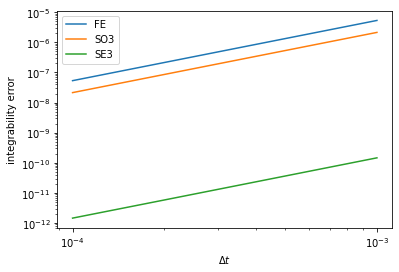

<Figure size 432x288 with 0 Axes>

In [19]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('integrability error')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(df['dt'], df[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'integrability_error__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

In [20]:
df = {}

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    df[ig] = []
    df[ig + "_sim_run_time"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        
        if sim_res is None:
            df[ig].append(np.nan)
            df[ig + "_sim_run_time"].append(np.nan)
            
        else:
            err = sim_res['integrability_err0']
            df[ig].append(err)
            df[ig + "_sim_run_time"].append(sim_res['sim_run_time'])
            
df = pd.DataFrame(df)
df.to_csv(Path(data_path, 'integrability_errs__v__sim_run_time.csv'))

df.head()

,FE,FE_sim_run_time,SO3,SO3_sim_run_time,SE3,SE3_sim_run_time
0,NaN,NaN,NaN,NaN,NaN,NaN
1,5.346254e-06,0.000686,2.141718e-06,0.000987,1.460605e-10,0.000686
2,2.138502e-07,0.000712,8.568896e-08,0.001010,5.808337e-12,0.001105
3,5.346254e-08,0.000755,2.142287e-08,0.000733,1.453846e-12,0.001230


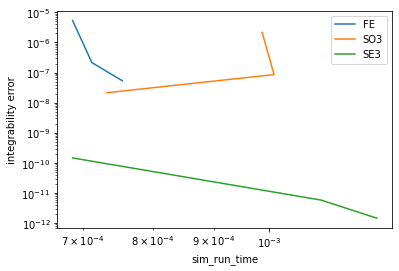

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = df['%s_sim_run_time' % ig]
    errs = df[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time')
ax.set_ylabel('integrability error')

plt.xscale('log')
plt.yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'integrability_error__v__sim_run_time.pdf'),bbox_inches='tight')
plt.tight_layout()

In [22]:
df = {}

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    df[ig] = []
    df[ig + "_sim_run_time2"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        
        if sim_res is None:
            df[ig].append(np.nan)
            df[ig + "_sim_run_time"].append(np.nan)
            
        else:
            err = sim_res['integrability_err0']
            df[ig].append(err)
            df[ig + "_sim_run_time2"].append(sim_res['sim_run_time2'])
            
df = pd.DataFrame(df)
df.to_csv(Path(data_path, 'integrability_errs__v__sim_run_time2.csv'))

df.head()

KeyError: 'FE_sim_run_time'

In [ ]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = df['%s_sim_run_time2' % ig]
    errs = df[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time2')
ax.set_ylabel('integrability error')

plt.xscale('log')
plt.yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'integrability_error__v__sim_run_time2.pdf'),bbox_inches='tight')
plt.tight_layout()

#### `Rf_sup_errs__v__dt`

In [ ]:
Rf_sup_errs__v__dt = {}
Rf_sup_errs__v__dt['dt'] = dts

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    Rf_sup_errs__v__dt[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__dt[ig].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__dt[ig].append(err)

df = pd.DataFrame(Rf_sup_errs__v__dt)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__dt.csv'))

df.head()

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(Rf_sup_errs__v__dt['dt'], Rf_sup_errs__v__dt[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### `Ef_sup_errs__v__dt`

In [ ]:
Ef_sup_errs__v__dt = {}
Ef_sup_errs__v__dt['dt'] = dts

ref_Ef = ref_sim_res['Ef']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    Ef_sup_errs__v__dt[ig] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Ef_sup_errs__v__dt[ig].append(np.nan)
        else:
            Ef = sim_res['Ef']
            err = np.max(np.abs(ref_Ef - Ef)) 
            Ef_sup_errs__v__dt[ig].append(err)

df = pd.DataFrame(Ef_sup_errs__v__dt)
df.to_csv(Path(data_path, 'Ef_sup_errs__v__dt.csv'))

df.head()

In [ ]:
fig, ax = plt.subplots()

ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Ef_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

for ig in integrators:
    ax.plot(Ef_sup_errs__v__dt['dt'], Ef_sup_errs__v__dt[integrator_to_label[ig]], label=integrator_to_label[ig])
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Ef_sup_errs__v__dt.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__sim_run_time

In [ ]:
Rf_sup_errs__v__sim_run_time = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__sim_run_time[ig] = []
    Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__sim_run_time[ig].append(np.nan)
            Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__sim_run_time[ig].append(err)
            Rf_sup_errs__v__sim_run_time[ig + "_sim_run_time"].append(sim_res['sim_run_time'])

df = pd.DataFrame(Rf_sup_errs__v__sim_run_time)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__sim_run_time.csv'))

df.head()

In [ ]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__sim_run_time['%s_sim_run_time' % ig]
    errs = Rf_sup_errs__v__sim_run_time[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time')
ax.set_ylabel('Rf_sup_err')

plt.xscale('log')
plt.yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__sim_run_time.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__sim_run_time2

In [ ]:
Rf_sup_errs__v__sim_run_time2 = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__sim_run_time2[ig] = []
    Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"] = []
    
    for dt, sim_res in zip(dts, dts_sim_res[igf]):
        if sim_res is None:
            Rf_sup_errs__v__sim_run_time2[ig].append(np.nan)
            Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__sim_run_time2[ig].append(err)
            Rf_sup_errs__v__sim_run_time2[ig + "_sim_run_time2"].append(sim_res['sim_run_time2'])

df = pd.DataFrame(Rf_sup_errs__v__sim_run_time2)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__sim_run_time2.csv'))

df.head()

In [ ]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__sim_run_time2['%s_sim_run_time2' % ig]
    errs = Rf_sup_errs__v__sim_run_time2[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('sim_run_time2')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')

plt.xscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__sim_run_time2.pdf'),bbox_inches='tight')
plt.tight_layout()

#### Rf_sup_errs__v__integrator_time

In [ ]:
Rf_sup_errs__v__integrator_time = {}

ref_Rf = ref_sim_res['Rf']

for igf in dts_sim_res.keys():
    ig = integrator_to_label[igf]
    
    Rf_sup_errs__v__integrator_time[ig] = []
    Rf_sup_errs__v__integrator_time[ig + "_integrator_time"] = []
    
    for dt, sim_res, stats in zip(dts, dts_sim_res[igf], dts_stats[igf]):
        if sim_res is None:
            Rf_sup_errs__v__integrator_time[ig].append(np.nan)
            Rf_sup_errs__v__integrator_time[ig + "_integrator_time"].append(np.nan)
        else:
            Rf = sim_res['Rf']
            err = np.max(np.abs(ref_Rf - Rf)) 
            Rf_sup_errs__v__integrator_time[ig].append(err)
            Rf_sup_errs__v__integrator_time[ig + "_integrator_time"].append(stats['integrator_time'])

df = pd.DataFrame(Rf_sup_errs__v__integrator_time)
df.to_csv(Path(data_path, 'Rf_sup_errs__v__integrator_time.csv'))

df.head()

In [ ]:
fig, ax = plt.subplots()

for ig in integrator_to_label.values():
    sim_run_times = Rf_sup_errs__v__integrator_time['%s_integrator_time' % ig]
    errs = Rf_sup_errs__v__integrator_time[ig]
    ax.plot(sim_run_times, errs, label=ig)
    
ax.set_xlabel('integrator_time')
ax.set_ylabel('Rf_sup_err')

ax.set_xscale('log')
ax.set_yscale('log')
    
ax.legend()
plt.show()
fig.savefig(Path(data_path, 'figs', 'Rf_sup_errs__v__integrator_time.pdf'),bbox_inches='tight')
plt.tight_layout()